In [133]:
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
import os
import fiona
from statistics import mean, median
from pandas import read_csv
gp.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' #To load KML files
import string
import xml.etree.ElementTree as et

# VEST UT 2016

## VEST Documentation

### Election Results

#### Sources

Election results from OpenElections.

#### Processing

Shapefile from the Utah Geographic Reference Center (https://gis.utah.gov/data/political/voter-precincts/).

The shapefile from the UGRC is of subprecincts, breaking down precincts in cases of district splits. In some cases, results are reported at the subprecinct level, in most cases, they weren't, so merging was done where necessary.

### Election Results Processing

#### Load in the VEST file

In [134]:
ut_vest = gp.read_file("raw-from-source/ut_2016/ut_2016.shp")

In [135]:
ut_vest.crs

<Projected CRS: EPSG:26912>
Name: NAD83 / UTM zone 12N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 114°W and 108°W - onshore and offshore. Canada - Alberta; Northwest Territories; Nunavut; Saskatchewan. United States (USA) - Arizona; Colorado; Idaho; Montana; New Mexico; Utah; Wyoming.
- bounds: (-114.0, 31.332603454538, -108.0, 84.0)
Coordinate Operation:
- name: UTM zone 12N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

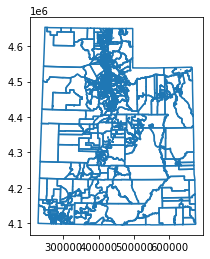

In [136]:
ut_vest.boundary.plot()

In [137]:
ut_vest.columns

Index(['CountyID', 'PrecinctID', 'county', 'precinct', 'G16PRERTRU',
       'G16PREDCLI', 'G16PRELJOH', 'G16PREISTE', 'G16PREIMCM', 'G16PREOOTH',
       'G16USSRLEE', 'G16USSDSNO', 'G16USSAFON', 'G16USSIBAR', 'G16GOVRHER',
       'G16GOVDWEI', 'G16GOVLKAM', 'G16GOVASCH', 'G16ATGRREY', 'G16ATGDHAR',
       'G16ATGLMCC', 'G16ATGAISB', 'G16AUDRDOU', 'G16AUDDMIT', 'G16AUDAGRE',
       'G16TRERDAM', 'G16TREDHAN', 'G16TRECPRO', 'geometry'],
      dtype='object')

In [138]:
ut_vest.head(5)

,CountyID,PrecinctID,county,precinct,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PREISTE,G16PREIMCM,G16PREOOTH,...,G16ATGDHAR,G16ATGLMCC,G16ATGAISB,G16AUDRDOU,G16AUDDMIT,G16AUDAGRE,G16TRERDAM,G16TREDHAN,G16TRECPRO,geometry
0,1,BV01,Beaver,Beaver 1,469,46,6,1,83,3,...,48,18,17,481,69,27,454,80,36,"POLYGON ((358362.560 4238423.840, 358372.350 4..."
1,1,BV02,Beaver,Beaver 2,334,38,4,4,74,4,...,48,25,14,345,72,21,329,90,19,"POLYGON ((355866.750 4240506.080, 356860.230 4..."
2,1,BV03,Beaver,Beaver 3,268,22,3,0,49,2,...,31,6,11,269,44,14,254,52,18,"POLYGON ((358902.400 4261055.000, 358909.700 4..."
3,1,BV04,Beaver,Beaver 4,101,10,3,0,23,0,...,16,9,3,92,23,12,94,19,14,"POLYGON ((367866.500 4262536.100, 367842.500 4..."
4,1,GR01,Beaver,Greenville,76,10,0,2,4,0,...,12,0,0,67,16,0,57,20,5,"POLYGON ((348977.460 4223848.220, 348973.090 4..."


In [139]:
ut_vest.shape

(2296, 29)

#### make sure CountyID + PrecinctID is a unique column

In [140]:
ut_vest_copy = ut_vest
ut_vest_copy['uniqueid'] = ut_vest_copy['CountyID'].astype(str) + '-' + ut_vest_copy['PrecinctID'].astype(str)
assert(len(ut_vest['uniqueid']) == len(ut_vest['uniqueid'].unique()))

## Election Results

### Load, Clean, Pivot Election Results

#### Load in the OpenElections general election results for 2016 at precinct level

Load in individual counties' election data 

In [141]:
file_list = os.listdir("./raw-from-source/counties")
li = []
for file in file_list:
    #print(file)
    if "general" in file:
        #print(file)
        file_ref = "./raw-from-source/counties/"+file
        file_prev = pd.read_csv(file_ref)
        if 'precincts' in file_prev.columns:
            file_prev['precinct'] = file_prev['precincts']
     
        file_prev = file_prev[['county', 'precinct', 'office', 'district', 'party', 'candidate','votes']]
        li.append(file_prev)
county_df = pd.concat(li, axis=0, ignore_index=True)
display(county_df)

,county,precinct,office,district,party,candidate,votes
0,San Pete,FAIRVIEW MUNICIPAL,President,NaN,NaN,Rocky De La Fuente,0.0
1,San Pete,FAIRVIEW MUNICIPAL,President,NaN,NaN,Jill Stein,2.0
2,San Pete,FAIRVIEW MUNICIPAL,President,NaN,NaN,Alyson Kennedy,0.0
3,San Pete,FAIRVIEW MUNICIPAL,President,NaN,Libertarian,Gary Johnson,12.0
4,San Pete,FAIRVIEW MUNICIPAL,President,NaN,Independent American,Rocky Giordani,0.0
...,...,...,...,...,...,...,...
97152,Salt Lake,SJD023,State House,52.0,Republican,John Knotwell,386.0
97153,Salt Lake,SJD025,State House,52.0,Republican,John Knotwell,377.0
97154,Salt Lake,SJD029,State House,52.0,Republican,John Knotwell,429.0
97155,Salt Lake,SWT001,State House,52.0,Republican,John Knotwell,266.0


Isolate the races used by VEST

In [142]:
list_of_races = ['President', 'U.S. Senate', 'Governor', 'Attorney General', 'State Auditor', 'State Treasurer']
clean_df = county_df[county_df['office'].isin(list_of_races)]

In [143]:
# candidate_office column is used to create unique candidate pivot column
# in case of same last name candidates running for different positions
clean_df['candidate_office'] = clean_df['candidate'] + '/' + clean_df['office']
display(clean_df)

<ipython-input-143-1233adbab03b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['candidate_office'] = clean_df['candidate'] + '/' + clean_df['office']


,county,precinct,office,district,party,candidate,votes,candidate_office
0,San Pete,FAIRVIEW MUNICIPAL,President,NaN,NaN,Rocky De La Fuente,0.0,Rocky De La Fuente/President
1,San Pete,FAIRVIEW MUNICIPAL,President,NaN,NaN,Jill Stein,2.0,Jill Stein/President
2,San Pete,FAIRVIEW MUNICIPAL,President,NaN,NaN,Alyson Kennedy,0.0,Alyson Kennedy/President
3,San Pete,FAIRVIEW MUNICIPAL,President,NaN,Libertarian,Gary Johnson,12.0,Gary Johnson/President
4,San Pete,FAIRVIEW MUNICIPAL,President,NaN,Independent American,Rocky Giordani,0.0,Rocky Giordani/President
...,...,...,...,...,...,...,...,...
94885,Salt Lake,WVC076,State Treasurer,NaN,Republican,David Damschen,52.0,David Damschen/State Treasurer
94886,Salt Lake,WVC077,State Treasurer,NaN,Republican,David Damschen,106.0,David Damschen/State Treasurer
94887,Salt Lake,WVC078,State Treasurer,NaN,Republican,David Damschen,133.0,David Damschen/State Treasurer
94888,Salt Lake,WVC079,State Treasurer,NaN,Republican,David Damschen,107.0,David Damschen/State Treasurer


In [144]:
clean_df.shape

(83574, 8)

Clean the resulting dataframe to remove nan and Null rows from the dataframe

In [145]:
cand_list = clean_df.candidate.unique()
cand_list = [x for x in cand_list if pd.isnull(x) == False and x != 'nan']

cand_office_list = clean_df.candidate_office.unique()
cand_office_list = [x for x in cand_office_list if pd.isnull(x) == False and x != 'nan']

print('number of rows in original dataframe is:', len(clean_df))

null_precincts = (clean_df[clean_df['candidate_office'].isnull()]) #precincts where candidate is NaN
non_null_df = clean_df.drop(null_precincts.index)

# ensure both null precincts and non null precincts add up to original df
assert(len(null_precincts) + len(non_null_df) == len(clean_df))

number of rows in original dataframe is: 83574


Some precincts record candidate by the party as opposed to by name - the 'party' column will be used here instead of the 'candidate' column

In [146]:


party_precincts = null_precincts[null_precincts['party'].isin(cand_list)]
party_precincts['candidate_office'] = party_precincts['party'] + '/' + party_precincts['office']
cand_office_df = pd.concat([non_null_df, party_precincts])
display(cand_office_df)
nan_precincts = null_precincts.drop(party_precincts.index)

print(len(cand_office_df), len(nan_precincts))
registered_voters = (nan_precincts[nan_precincts['party'].isnull()])
non_nan = nan_precincts.drop(registered_voters.index)
display(cand_office_df)

,county,precinct,office,district,party,candidate,votes,candidate_office
0,San Pete,FAIRVIEW MUNICIPAL,President,NaN,NaN,Rocky De La Fuente,0.0,Rocky De La Fuente/President
1,San Pete,FAIRVIEW MUNICIPAL,President,NaN,NaN,Jill Stein,2.0,Jill Stein/President
2,San Pete,FAIRVIEW MUNICIPAL,President,NaN,NaN,Alyson Kennedy,0.0,Alyson Kennedy/President
3,San Pete,FAIRVIEW MUNICIPAL,President,NaN,Libertarian,Gary Johnson,12.0,Gary Johnson/President
4,San Pete,FAIRVIEW MUNICIPAL,President,NaN,Independent American,Rocky Giordani,0.0,Rocky Giordani/President
...,...,...,...,...,...,...,...,...
52163,Wayne,Hanksville,President,NaN,Jill Stein,NaN,0.0,Jill Stein/President
52164,Wayne,Hanksville,President,NaN,Alyson Kennedy,NaN,0.0,Alyson Kennedy/President
52170,Wayne,Hanksville,President,NaN,Monica Moorehead,NaN,0.0,Monica Moorehead/President
52171,Wayne,Hanksville,President,NaN,Evan McMullin,NaN,20.0,Evan McMullin/President


83574 0


,county,precinct,office,district,party,candidate,votes,candidate_office
0,San Pete,FAIRVIEW MUNICIPAL,President,NaN,NaN,Rocky De La Fuente,0.0,Rocky De La Fuente/President
1,San Pete,FAIRVIEW MUNICIPAL,President,NaN,NaN,Jill Stein,2.0,Jill Stein/President
2,San Pete,FAIRVIEW MUNICIPAL,President,NaN,NaN,Alyson Kennedy,0.0,Alyson Kennedy/President
3,San Pete,FAIRVIEW MUNICIPAL,President,NaN,Libertarian,Gary Johnson,12.0,Gary Johnson/President
4,San Pete,FAIRVIEW MUNICIPAL,President,NaN,Independent American,Rocky Giordani,0.0,Rocky Giordani/President
...,...,...,...,...,...,...,...,...
52163,Wayne,Hanksville,President,NaN,Jill Stein,NaN,0.0,Jill Stein/President
52164,Wayne,Hanksville,President,NaN,Alyson Kennedy,NaN,0.0,Alyson Kennedy/President
52170,Wayne,Hanksville,President,NaN,Monica Moorehead,NaN,0.0,Monica Moorehead/President
52171,Wayne,Hanksville,President,NaN,Evan McMullin,NaN,20.0,Evan McMullin/President


#### Prepare columns in source df for pivot

Create a candidate dictionary to translate from name + race to race code

In [147]:
cand_office_df["votes"] = cand_office_df["votes"].fillna(0)

In [148]:
for val in list(cand_office_df["candidate_office"].unique()):
    print(str(val))
    print(sum(cand_office_df[cand_office_df["candidate_office"]==val]["votes"]))

Rocky De La Fuente/President
762.0
Jill Stein/President
9438.0
Alyson Kennedy/President
521.0
Gary Johnson/President
39590.0
Rocky Giordani/President
2136.0
Donald Trump/President
514265.0
Darrell Castle/President
7349.0
Hillary Clinton/President
310405.0
Monica Moorehead/President
894.0
Evan McMullin/President
243339.0
Write In/President
85.0
Misty Snow/U.S. Senate
293222.0
Bill Barron/U.S. Senate
26167.0
Stoney Fonua/U.S. Senate
27317.0
Mike Lee/U.S. Senate
759161.0
Gary Herbert/Governor
829768.0
Dell Schanze/Governor
20311.0
Brian Kamerath/Governor
44898.0
Mike Weinholtz/Governor
504536.0
Write In/Governor
18.0
Michael Isbell/Attorney General
29323.0
Jon Harper/Attorney General
267757.0
Sean Reyes/Attorney General
685786.0
W. Andrew McCullough/Attorney General
73919.0
John Dougall/State Auditor
678684.0
Jared Green/State Auditor
56918.0
Mike Mitchell/State Auditor
329320.0
Richard Proctor/State Treasurer
75305.0
Neil Hansen/State Treasurer
294477.0
David Damschen/State Treasurer
649

In [149]:
cand_dict = {
    
    'Donald Trump/President': 'G16PRERTRU', 
    'Republican/President': 'G16PRERTRU', 

    'Hillary Clinton/President': 'G16PREDCLI', 
    'Democratic/President': 'G16PREDCLI', 

    'Gary Johnson/President': 'G16PRELJOH',
    'Libertarian/President': 'G16PRELJOH', 
    
    'Jill Stein/President': 'G16PREISTE', 
    
    'Evan McMullin/President': 'G16PREIMCM', 


    'Rocky De La Fuente/President': 'G16PREOOTH', 
    'Alyson Kennedy/President': 'G16PREOOTH', 
    'Rocky Giordani/President': 'G16PREOOTH', 
    'Darrell Castle/President': 'G16PREOOTH', 
    'Monica Moorehead/President': 'G16PREOOTH', 
     
    'Fuente/President': 'G16PREOOTH', 
    'Giordani/President': 'G16PREOOTH', 
    'Stephen Park/President': 'G16PREOOTH', 
    'Limbaugh/President': 'G16PREOOTH',
    'Tony Valdivia/President': 'G16PREOOTH', 
    'Fox/President': 'G16PREOOTH',
    'Sheila Samm Tittle/President': 'G16PREOOTH', 
    'Buchnan/President': 'G16PREOOTH', 
    'Marshall Schoenke/President': 'G16PREOOTH', 
    'Janet Reid/President': 'G16PREOOTH', 
    'Burton/President': 'G16PREOOTH', 
    'Giordani,Rocky/President': 'G16PREOOTH',
    'Roque De La Fuente/President': 'G16PREOOTH', 
    'Darrell L. Castle/President': 'G16PREOOTH', 
    'Tony Valdiva/President': 'G16PREOOTH',
    "'Rocky' De La Fuente/President": 'G16PREOOTH', 
    'Giordani/Anderson/President': 'G16PREOOTH', 
    'Independent American/President': 'G16PREOOTH', 
    'Constitution/President': 'G16PREOOTH', 
    'Stephen Paul Parks/President': 'G16PREOOTH', 
    'Jamin Burton/President': 'G16PREOOTH', 
    'Robert Buchanan/President': 'G16PREOOTH', 
    'Cherunda Fox/President': 'G16PREOOTH', 
    'David Limbaugh/President': 'G16PREOOTH',
    'Write-ins/President': None,
    'Write-In/President': None,
    'Write In/President': None,
    'Laurence Kotlikoff/President': None,
    'Andrew Basiago/President': None, 
    'Emidio Soltyisk/President': None,
    'Tom Hoefling/President': None, 
    'Emidio Soltysik/President': None, 
    'Hoefling/President': None,
    'Dustin Baird/President': None,
    'Mike Smith/President': None,
    
    'Mike Lee/U.S. Senate': 'G16USSRLEE',
    'Republican/U.S. Senate': 'G16USSRLEE', 
    
    'Misty Snow/U.S. Senate': 'G16USSDSNO', 
    'Misty K. Snow/U.S. Senate': 'G16USSDSNO',
    'Democratic/U.S. Senate': 'G16USSDSNO', 

    'Stoney Fonua/U.S. Senate': 'G16USSAFON', 
    'Independent American/U.S. Senate': 'G16USSAFON', 

    'Bill Barron/U.S. Senate': 'G16USSIBAR', 

    
    
    'Gary Herbert/Governor': 'G16GOVRHER', 
    'Gary R. Herbert/Governor': 'G16GOVRHER', 
    'Gray Herbert/Governor': 'G16GOVRHER', 
    'Republican/Governor': 'G16GOVRHER', 
    'Herbert/Governor': 'G16GOVRHER', 

    'Mike Weinholtz/Governor': 'G16GOVDWEI', 
    'Democratic/Governor': 'G16GOVDWEI', 

    'Brian Kamerath/Governor': 'G16GOVLKAM', 
    'Brian E. Kamerath/Governor': 'G16GOVLKAM',
    'Libertarian/Governor': 'G16GOVLKAM', 

    'Dell Schanze/Governor': 'G16GOVASCH', 
    'Superdell Schanze/Governor': 'G16GOVASCH', 
    'Independent American/Governor': 'G16GOVASCH', 
    
    # no write-in race code was created for Governor
    'L.S. Brown/Governor': None, 
    'Write In/Governor': None, 
    'Write-In/Governor': None, 
    'Write-ins/Governor': None, 

    
    
    'Sean Reyes/Attorney General': 'G16ATGRREY', 
    'Sean D. Reyes/Attorney General': 'G16ATGRREY',
    'Republican/Attorney General': 'G16ATGRREY', 

    'Jon V. Harper/Attorney General': 'G16ATGDHAR', 
    'Jon Harper/Attorney General': 'G16ATGDHAR', 
    'Democratic/Attorney General': 'G16ATGDHAR', 

    'W. Andrew McCullough/Attorney General': 'G16ATGLMCC', 
    'Libertarian/Attorney General': 'G16ATGLMCC', 
    
    'Michael Isbell/Attorney General': 'G16ATGAISB', 
    'Michael W. Isbell/Attorney General': 'G16ATGAISB', 
    'Independent American/Attorney General': 'G16ATGAISB', 

    
    
    'John Dougall/State Auditor': 'G16AUDRDOU', 
    'Republican/State Auditor': 'G16AUDRDOU', 
    
    'Mike Mitchell/State Auditor': 'G16AUDDMIT', 
    'Democratic/State Auditor': 'G16AUDDMIT', 

    'Jared Green/State Auditor': 'G16AUDAGRE', 
    'Independent American/State Auditor': 'G16AUDAGRE', 
    
    # CHANGED
    'Green/State Auditor': 'G16AUDAGRE', 

    
    
    'David Damschen/State Treasurer': 'G16TRERDAM', 
    'Davad Damschen/State Treasurer': 'G16TRERDAM',
    'Republican/State Treasurer': 'G16TRERDAM',
    
    'Neil A. Hansen/State Treasurer': 'G16TREDHAN',
    'Neil Hansen/State Treasurer': 'G16TREDHAN', 
    'Hansen/State Treasurer': 'G16TREDHAN',
    'Democratic/State Treasurer': 'G16TREDHAN', 

    'Richard Proctor/State Treasurer': 'G16TRECPRO', 
    'Constitution/State Treasurer': 'G16TRECPRO'
}

Map the candidate names + race using the dictionary

In [150]:
cand_office_df['CandidateID'] = cand_office_df['candidate_office'].map(cand_dict)

In [151]:
cand_office_df['candidate_office'].value_counts(dropna=False)

Jill Stein/President              2224
Evan McMullin/President           2224
Alyson Kennedy/President          2224
Bill Barron/U.S. Senate           2224
Monica Moorehead/President        2224
                                  ... 
Constitution/President               7
Independent American/President       7
Democratic/Governor                  7
Democratic/President                 7
Giordani/Anderson/President          5
Name: candidate_office, Length: 100, dtype: int64

Remove null rows (entries that do not include the races VEST merged)

In [152]:
race_df = cand_office_df[~cand_office_df['CandidateID'].isnull()]

Ensure that dropped entries add up to number of entries recorded by VEST

In [153]:
dropped_votes = [
    'L.S. Brown/Governor',
    'Write In/Governor',
    'Write-In/Governor',
    'Write-ins/Governor',
]


dropped_df = cand_office_df[cand_office_df['candidate_office'].isin(dropped_votes)]
print('Length of total dataframe: ', len(cand_office_df))
print('Length of cleaned df plus candidates not recorded by VEST: ', (len(race_df) + len(dropped_df)))
assert(len(cand_office_df) == len(race_df) + len(dropped_df))



Length of total dataframe:  83574
Length of cleaned df plus candidates not recorded by VEST:  75007


AssertionError: 

Create county name to num dictionary

In [154]:
#county cast
county_to_num = {
    'Beaver': 1, 
    'Box Elder': 2, 
    'Cache': 3, 
    'Carbon': 4, 
    'Daggett': 5, 
    'Davis': 6, 
    'Duchesne': 7,
    'Emery': 8, 
    'Garfield': 9, 
    'Grand': 10, 
    'Iron': 11, 
    'Juab': 12, 
    'Kane': 13, 
    'Millard': 14, 
    'Morgan': 15, 
    'Piute': 16, 
    'Rich': 17, 
    'Salt Lake': 18,
    'San Juan': 19, 
    'Sanpete': 20, 
    'San Pete': 20, 
    'Sevier': 21, 
    'Summit': 22, 
    'Tooele': 23,
    'Uintah': 24, 
    'Utah': 25,
    'Wasatch': 26,
    'Washington': 27,
    'Wayne': 28,
    'Weber': 29
}

Use the dictionary to create a county num column

In [155]:
cand_office_df['CountyID'] = cand_office_df['county'].map(county_to_num).astype(int)
race_df['CountyID'] = race_df['county'].map(county_to_num).astype(int)

<ipython-input-155-85f9849ba26e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_df['CountyID'] = race_df['county'].map(county_to_num).astype(int)


Create a unique column by combining county num and precinct name

In [156]:
cand_office_df['mergeid'] = cand_office_df['CountyID'].astype(str)+'-'+cand_office_df['precinct']
race_df['mergeid'] = race_df['CountyID'].astype(str)+'-'+cand_office_df['precinct']

<ipython-input-156-b3de8fcdab48>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_df['mergeid'] = race_df['CountyID'].astype(str)+'-'+cand_office_df['precinct']


Create a race code dictionary

In [157]:
races = [
    'G16ATGAISB', 'G16ATGDHAR', 'G16ATGLMCC', 'G16ATGRREY',
    'G16AUDAGRE', 'G16AUDDMIT', 'G16AUDRDOU', 'G16GOVASCH',
    'G16GOVDWEI', 'G16GOVLKAM', 'G16GOVRHER', 'G16PREDCLI',
    'G16PREIMCM', 'G16PREISTE', 'G16PRELJOH', 'G16PREOOTH',
    'G16PRERTRU', 'G16TRECPRO', 'G16TREDHAN', 'G16TRERDAM',
    'G16USSAFON', 'G16USSDSNO', 'G16USSIBAR', 'G16USSRLEE'
]

#### Pivot the dataframe to match VEST

In [158]:
pivoted_df = pd.pivot_table(race_df,values=["votes"],index=["mergeid"],columns=["CandidateID"],aggfunc='sum')
#pivoted_df = pd.pivot_table(cand_office_df,values=["votes"],index=["mergeid"],columns=["CandidateID"],aggfunc='sum')
pivoted_df=pivoted_df.fillna(0)
pivoted_df.reset_index(drop=False,inplace=True)
pivoted_df.columns = pivoted_df.columns.droplevel(0)

pivoted_df.columns = ['joinid'] + races

display(pivoted_df)

,joinid,G16ATGAISB,G16ATGDHAR,G16ATGLMCC,G16ATGRREY,G16AUDAGRE,G16AUDDMIT,G16AUDRDOU,G16GOVASCH,G16GOVDWEI,...,G16PRELJOH,G16PREOOTH,G16PRERTRU,G16TRECPRO,G16TREDHAN,G16TRERDAM,G16USSAFON,G16USSDSNO,G16USSIBAR,G16USSRLEE
0,1-Beaver 1,17.0,48.0,18.0,507.0,27.0,69.0,481.0,13.0,53.0,...,6.0,3.0,469.0,36.0,80.0,454.0,12.0,48.0,3.0,530.0
1,1-Beaver 2,14.0,48.0,25.0,363.0,21.0,72.0,345.0,4.0,51.0,...,4.0,4.0,334.0,19.0,90.0,329.0,8.0,48.0,4.0,390.0
2,1-Beaver 3,11.0,31.0,6.0,289.0,14.0,44.0,269.0,10.0,22.0,...,3.0,2.0,268.0,18.0,52.0,254.0,8.0,30.0,2.0,300.0
3,1-Beaver 4,3.0,16.0,9.0,100.0,12.0,23.0,92.0,0.0,15.0,...,3.0,0.0,101.0,14.0,19.0,94.0,3.0,7.0,4.0,116.0
4,1-Greenville,0.0,12.0,0.0,74.0,0.0,16.0,67.0,1.0,14.0,...,0.0,0.0,76.0,5.0,20.0,57.0,0.0,13.0,0.0,77.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2220,9-Henrieville,1.0,11.0,10.0,94.0,9.0,20.0,87.0,0.0,16.0,...,2.0,0.0,75.0,15.0,21.0,81.0,4.0,13.0,0.0,101.0
2221,9-Pang1,14.0,45.0,18.0,430.0,28.0,62.0,407.0,7.0,41.0,...,11.0,2.0,391.0,22.0,68.0,409.0,4.0,49.0,2.0,464.0
2222,9-Pang2,4.0,33.0,9.0,343.0,10.0,48.0,323.0,7.0,37.0,...,7.0,1.0,302.0,23.0,41.0,320.0,5.0,31.0,1.0,357.0
2223,9-Ticaboo,0.0,4.0,7.0,12.0,4.0,5.0,14.0,2.0,3.0,...,0.0,1.0,14.0,6.0,4.0,13.0,0.0,7.0,2.0,15.0


#### Remove Total votes

In [159]:
#County 18
df18 = pivoted_df[pivoted_df.joinid.str.startswith('18-')]
df18_total = df18[df18.joinid == '18-Election Total']
df18_non_total = df18.drop(df18_total.index)
df18_non_total.loc["totals"] = df18_non_total.sum(axis = 0)
display(df18_non_total.loc['totals'])
display(df18_total)
for cand in races:
    if int(df18_total[cand]) != 0:
        print('For county 11 and race', cand)
        print('The totals provided by the totals row are:', int(df18_total[cand]))
        print('The totals as a result of the sum of the votes in each precinct are:', df18_non_total.loc['totals'][cand])
        print('And their difference is:', (int(df18_total[cand]) - df18_non_total.loc['totals'][cand]))
        print()

joinid        18-ALT00118-BLF00118-BLF00318-BLF00418-BLF0051...
G16ATGAISB                                              10692.0
G16ATGDHAR                                             151565.0
G16ATGLMCC                                              30029.0
G16ATGRREY                                             212678.0
G16AUDAGRE                                              23226.0
G16AUDDMIT                                             175515.0
G16AUDRDOU                                             194859.0
G16GOVASCH                                               5094.0
G16GOVDWEI                                             181462.0
G16GOVLKAM                                              11671.0
G16GOVRHER                                             218570.0
G16PREDCLI                                             175863.0
G16PREIMCM                                              79880.0
G16PREISTE                                               4965.0
G16PRELJOH                              

,joinid,G16ATGAISB,G16ATGDHAR,G16ATGLMCC,G16ATGRREY,G16AUDAGRE,G16AUDDMIT,G16AUDRDOU,G16GOVASCH,G16GOVDWEI,...,G16PRELJOH,G16PREOOTH,G16PRERTRU,G16TRECPRO,G16TREDHAN,G16TRERDAM,G16USSAFON,G16USSDSNO,G16USSIBAR,G16USSRLEE
229,18-Election Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5094.0,181462.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


For county 11 and race G16GOVASCH
The totals provided by the totals row are: 5094
The totals as a result of the sum of the votes in each precinct are: 5094.0
And their difference is: 0.0

For county 11 and race G16GOVDWEI
The totals provided by the totals row are: 181462
The totals as a result of the sum of the votes in each precinct are: 181462.0
And their difference is: 0.0

For county 11 and race G16GOVLKAM
The totals provided by the totals row are: 11671
The totals as a result of the sum of the votes in each precinct are: 11671.0
And their difference is: 0.0

For county 11 and race G16GOVRHER
The totals provided by the totals row are: 218570
The totals as a result of the sum of the votes in each precinct are: 218570.0
And their difference is: 0.0



Since the totals add up, we can safely remove the Election Total row

In [160]:
pivoted_df = pivoted_df.drop(pivoted_df[pivoted_df.joinid == '18-Election Total'].index)
pivoted_df

,joinid,G16ATGAISB,G16ATGDHAR,G16ATGLMCC,G16ATGRREY,G16AUDAGRE,G16AUDDMIT,G16AUDRDOU,G16GOVASCH,G16GOVDWEI,...,G16PRELJOH,G16PREOOTH,G16PRERTRU,G16TRECPRO,G16TREDHAN,G16TRERDAM,G16USSAFON,G16USSDSNO,G16USSIBAR,G16USSRLEE
0,1-Beaver 1,17.0,48.0,18.0,507.0,27.0,69.0,481.0,13.0,53.0,...,6.0,3.0,469.0,36.0,80.0,454.0,12.0,48.0,3.0,530.0
1,1-Beaver 2,14.0,48.0,25.0,363.0,21.0,72.0,345.0,4.0,51.0,...,4.0,4.0,334.0,19.0,90.0,329.0,8.0,48.0,4.0,390.0
2,1-Beaver 3,11.0,31.0,6.0,289.0,14.0,44.0,269.0,10.0,22.0,...,3.0,2.0,268.0,18.0,52.0,254.0,8.0,30.0,2.0,300.0
3,1-Beaver 4,3.0,16.0,9.0,100.0,12.0,23.0,92.0,0.0,15.0,...,3.0,0.0,101.0,14.0,19.0,94.0,3.0,7.0,4.0,116.0
4,1-Greenville,0.0,12.0,0.0,74.0,0.0,16.0,67.0,1.0,14.0,...,0.0,0.0,76.0,5.0,20.0,57.0,0.0,13.0,0.0,77.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2220,9-Henrieville,1.0,11.0,10.0,94.0,9.0,20.0,87.0,0.0,16.0,...,2.0,0.0,75.0,15.0,21.0,81.0,4.0,13.0,0.0,101.0
2221,9-Pang1,14.0,45.0,18.0,430.0,28.0,62.0,407.0,7.0,41.0,...,11.0,2.0,391.0,22.0,68.0,409.0,4.0,49.0,2.0,464.0
2222,9-Pang2,4.0,33.0,9.0,343.0,10.0,48.0,323.0,7.0,37.0,...,7.0,1.0,302.0,23.0,41.0,320.0,5.0,31.0,1.0,357.0
2223,9-Ticaboo,0.0,4.0,7.0,12.0,4.0,5.0,14.0,2.0,3.0,...,0.0,1.0,14.0,6.0,4.0,13.0,0.0,7.0,2.0,15.0


### Check vote totals on race and county level between VEST and source

#### Confirm equal votes per race 

In [161]:
print("Printing differences below")
for race in races:
    if (sum(ut_vest[race])- pivoted_df[race].sum() != 0):
        print(race+" has a difference of "+str(sum(ut_vest[race])-pivoted_df[race].sum())+" votes")
        print("\tVEST: "+str(sum(ut_vest[race]))+" votes")
        print("\tSOURCES: "+str(pivoted_df[race].sum())+" votes")
    else:
        print(race + " is equal", "\tVEST: " + str(sum(ut_vest[race])), "\tRDH: " + str(pivoted_df[race].sum()))
print("")
print("All other races are equal")

Printing differences below
G16ATGAISB is equal 	VEST: 30687 	RDH: 30687.0
G16ATGDHAR is equal 	VEST: 275571 	RDH: 275571.0
G16ATGLMCC has a difference of 2.0 votes
	VEST: 73975 votes
	SOURCES: 73973.0 votes
G16ATGRREY is equal 	VEST: 719064 	RDH: 719064.0
G16AUDAGRE is equal 	VEST: 65692 	RDH: 65692.0
G16AUDDMIT is equal 	VEST: 329625 	RDH: 329625.0
G16AUDRDOU is equal 	VEST: 679675 	RDH: 679675.0
G16GOVASCH is equal 	VEST: 15912 	RDH: 15912.0
G16GOVDWEI is equal 	VEST: 323349 	RDH: 323349.0
G16GOVLKAM is equal 	VEST: 34827 	RDH: 34827.0
G16GOVRHER is equal 	VEST: 750850 	RDH: 750850.0
G16PREDCLI is equal 	VEST: 310676 	RDH: 310676.0
G16PREIMCM has a difference of 351.0 votes
	VEST: 243690 votes
	SOURCES: 243339.0 votes
G16PREISTE is equal 	VEST: 9438 	RDH: 9438.0
G16PRELJOH is equal 	VEST: 39608 	RDH: 39608.0
G16PREOOTH has a difference of -345.0 votes
	VEST: 12740 votes
	SOURCES: 13085.0 votes
G16PRERTRU is equal 	VEST: 515231 	RDH: 515231.0
G16TRECPRO is equal 	VEST: 75365 	RDH: 753

#### Confirm equal votes per county

In [162]:
print(pivoted_df)

             joinid  G16ATGAISB  G16ATGDHAR  G16ATGLMCC  G16ATGRREY  \
0        1-Beaver 1        17.0        48.0        18.0       507.0   
1        1-Beaver 2        14.0        48.0        25.0       363.0   
2        1-Beaver 3        11.0        31.0         6.0       289.0   
3        1-Beaver 4         3.0        16.0         9.0       100.0   
4      1-Greenville         0.0        12.0         0.0        74.0   
...             ...         ...         ...         ...         ...   
2220  9-Henrieville         1.0        11.0        10.0        94.0   
2221        9-Pang1        14.0        45.0        18.0       430.0   
2222        9-Pang2         4.0        33.0         9.0       343.0   
2223      9-Ticaboo         0.0         4.0         7.0        12.0   
2224       9-Tropic         2.0        23.0         8.0       229.0   

      G16AUDAGRE  G16AUDDMIT  G16AUDRDOU  G16GOVASCH  G16GOVDWEI  ...  \
0           27.0        69.0       481.0        13.0        53.0  ...   
1

#### Distribute Canvas votes

Create a county column in the df

In [163]:
pivoted_df['county'] = pivoted_df['joinid'].apply(lambda x: x.split('-')[0])

Isolate county 8 from other counties

In [164]:
print(races)

['G16ATGAISB', 'G16ATGDHAR', 'G16ATGLMCC', 'G16ATGRREY', 'G16AUDAGRE', 'G16AUDDMIT', 'G16AUDRDOU', 'G16GOVASCH', 'G16GOVDWEI', 'G16GOVLKAM', 'G16GOVRHER', 'G16PREDCLI', 'G16PREIMCM', 'G16PREISTE', 'G16PRELJOH', 'G16PREOOTH', 'G16PRERTRU', 'G16TRECPRO', 'G16TREDHAN', 'G16TRERDAM', 'G16USSAFON', 'G16USSDSNO', 'G16USSIBAR', 'G16USSRLEE']


In [169]:
ut_vest.groupby(["CountyID"]).sum()["G16PREOOTH"]

CountyID
1       20
2      299
3      799
4      113
5        7
6     1408
7       79
8       47
9       17
10      27
11     249
12      60
13      29
14     118
15      76
16       8
17      12
18    3796
19      62
20     174
21      99
22      93
23     353
24     178
25    2841
26     148
27     696
28      19
29     913
Name: G16PREOOTH, dtype: int64

In [170]:
pivoted_df.columns

Index(['joinid', 'G16ATGAISB', 'G16ATGDHAR', 'G16ATGLMCC', 'G16ATGRREY',
       'G16AUDAGRE', 'G16AUDDMIT', 'G16AUDRDOU', 'G16GOVASCH', 'G16GOVDWEI',
       'G16GOVLKAM', 'G16GOVRHER', 'G16PREDCLI', 'G16PREIMCM', 'G16PREISTE',
       'G16PRELJOH', 'G16PREOOTH', 'G16PRERTRU', 'G16TRECPRO', 'G16TREDHAN',
       'G16TRERDAM', 'G16USSAFON', 'G16USSDSNO', 'G16USSIBAR', 'G16USSRLEE',
       'county'],
      dtype='object')

In [171]:
pivoted_df.groupby(["county"]).sum()["G16PREOOTH"]

county
1       20.0
10      27.0
11     249.0
12      60.0
13     381.0
14     118.0
15      76.0
16       8.0
17      12.0
18    3796.0
19      62.0
2      299.0
20     174.0
21      99.0
22      93.0
23     353.0
24     178.0
25    2841.0
26     148.0
27     696.0
28      19.0
29     913.0
3      791.0
4      113.0
5        5.0
6     1411.0
7       79.0
8       47.0
9       17.0
Name: G16PREOOTH, dtype: float64

In [172]:
pivoted_df.to_csv("./full_source.csv")

# Important Finding Below:

In [178]:
pivoted_df.columns

Index(['joinid', 'G16ATGAISB', 'G16ATGDHAR', 'G16ATGLMCC', 'G16ATGRREY',
       'G16AUDAGRE', 'G16AUDDMIT', 'G16AUDRDOU', 'G16GOVASCH', 'G16GOVDWEI',
       'G16GOVLKAM', 'G16GOVRHER', 'G16PREDCLI', 'G16PREIMCM', 'G16PREISTE',
       'G16PRELJOH', 'G16PREOOTH', 'G16PRERTRU', 'G16TRECPRO', 'G16TREDHAN',
       'G16TRERDAM', 'G16USSAFON', 'G16USSDSNO', 'G16USSIBAR', 'G16USSRLEE',
       'county'],
      dtype='object')

In [182]:
print(pivoted_df[pivoted_df["county"]=="13"][["joinid","G16PREOOTH"]])
ut_vest[ut_vest["CountyID"]=="13"][["uniqueid","G16PREOOTH"]]

     joinid  G16PREOOTH
85    13-AL        10.0
86    13-BU         1.0
87    13-BW        10.0
88    13-CM         6.0
89  13-CW:B         7.0
90  13-CW:C         0.0
91    13-GL        21.0
92    13-K1        39.0
93    13-K2        63.0
94    13-K3       105.0
95    13-K4        62.0
96    13-OR        57.0


,uniqueid,G16PREOOTH
441,13-AL,4
442,13-BU,0
443,13-BW,2
444,13-CM,0
445,13-CWC,0
446,13-GL,1
447,13-KA1,2
448,13-KA2,6
449,13-KA3,5
450,13-KA4,6


In [183]:
#Open Elections, switched votes for Moorhead and McMullin votes in Kane County (#13)
#https://github.com/openelections/openelections-sources-ut/blob/master/2016%20General%20Election/SOVC%20-%20Kane.pdf

In [174]:
ut_vest['CountyID'] = ut_vest['CountyID'].astype(str)
pivoted_df['county'] = pivoted_df['county'].astype(str)

data_columns = []

print("Counties with differences printed below:")
diff_counties=[]
for i in races:
    diff = ut_vest.groupby(["CountyID"]).sum()[i]-pivoted_df.groupby(["county"]).sum()[i]
    for val in diff[diff != 0].index.values.tolist():
        if val not in diff_counties:
            diff_counties.append(val)
    if len(diff[diff != 0]!=0):
        print(i)
        print(diff[diff != 0].to_string(header=False))
print("")
print("All other races in all counties are equal")

Counties with differences printed below:
G16ATGLMCC
11    2.0
G16PREIMCM
13    351.0
G16PREOOTH
13   -352.0
3       8.0
5       2.0
6      -3.0
G16USSRLEE
4    1.0

All other races in all counties are equal


In [ ]:
ut_vest.columns

In [ ]:
print(ut_vest.head())

In [ ]:
ut_vest[ut_vest["CountyID"]=="7"]

In [ ]:
ut_vest.columns

In [ ]:
pivoted_df = pivoted_df[['joinid','G16PRERTRU',
       'G16PREDCLI', 'G16PRELJOH', 'G16PREISTE', 'G16PREIMCM', 'G16PREOOTH',
       'G16USSRLEE', 'G16USSDSNO', 'G16USSAFON', 'G16USSIBAR', 'G16GOVRHER',
       'G16GOVDWEI', 'G16GOVLKAM', 'G16GOVASCH', 'G16ATGRREY', 'G16ATGDHAR',
       'G16ATGLMCC', 'G16ATGAISB', 'G16AUDRDOU', 'G16AUDDMIT', 'G16AUDAGRE',
       'G16TRERDAM', 'G16TREDHAN', 'G16TRECPRO','county']]

In [ ]:
ut_vest[ut_vest["CountyID"]=="7"].to_csv("./vest_7.csv")

In [ ]:
pivoted_df[pivoted_df["county"] == '7'].to_csv("./source_7.csv")

In [ ]:
county_8 = pivoted_df[pivoted_df["county"] == '8']
not_county_8 = pivoted_df[~(pivoted_df["county"] == '8')]

In [ ]:
assert(len(county_8) + len(not_county_8) == len(pivoted_df))

Isolate the precinct with Canvas votes

In [ ]:
county_8_canvas = county_8[county_8["joinid"] == '8-Canvas']
county_8_precincts = county_8[~(county_8["joinid"] == '8-Canvas')]

Create a dataframe that contains totals for each county that needs votes distributed

In [ ]:
to_dole_out_totals = pd.DataFrame(county_8_canvas.groupby(["county"]).sum())
to_dole_out_totals.reset_index(inplace=True,drop=False)

In [ ]:
precinct_specific_totals = pd.DataFrame(county_8.groupby(["county"]).sum())
precinct_specific_totals.reset_index(inplace=True,drop=False)

Distribute votes based on the voting population ratio

In [ ]:
#Create some new columns for each of these races to deal with the allocation
for race in races:
    add_var = race+"_add"
    rem_var = race+"_rem"
    floor_var = race+"_floor"
    county_8.loc[:,add_var]=0.0
    county_8.loc[:,rem_var]=0.0
    county_8.loc[:,floor_var]=0.0

#Iterate over the rows
#Note this function iterates over the dataframe two times so the rounded vote totals match the totals to allocate
for index, row in county_8.iterrows():
    for race in races:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        #Grab the district
        county_id = row["county"]
        #Get the denominator for the allocation (the precinct vote totals)
        denom = precinct_specific_totals.loc[precinct_specific_totals["county"]==county_id][race]
        #Get one of the numerators, how many districtwide votes to allocate
        numer = to_dole_out_totals.loc[to_dole_out_totals["county"]==county_id][race]
        #Get the vote totals for this race in this precinct
        val = county_8.at[index,race]
        #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
        if (float(denom==0)):
            vote_share = 0
        else:
            vote_share = (float(val)/float(denom))*float(numer)
        county_8.at[index,add_var] = vote_share
        #Take the decimal remainder of the allocation
        county_8.at[index,rem_var] = vote_share%1
        #Take the floor of the allocation
        county_8.at[index,floor_var] = np.floor(vote_share)

#After the first pass through, get the sums of the races by district to assist in the rounding            
first_allocation = pd.DataFrame(county_8.groupby(["county"]).sum())

#Now we want to iterate district by district to work on rounding
county_list = list(to_dole_out_totals["county"].unique()) 

#Iterate over the district
for county in county_list:
    for race in races:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
        to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals["county"]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
        #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
        for index in county_8.loc[county_8["county"]==county][rem_var].nlargest(to_go).index:
            county_8.at[index,add_var] = np.ceil(county_8.at[index,add_var])

#Iterate over every race again
for race in races:
    add_var = race+"_add"
    #Round every allocation down to not add fractional votes
    county_8.loc[:,add_var]=np.floor(county_8.loc[:,add_var])
    county_8.loc[:,race]+=county_8.loc[:,add_var]

#Print out any instances where the allocation, as written, won't work
for index, row in precinct_specific_totals.iterrows():
    for race in races:
        if (row[race]==0):
            race_district = row["county"]
            to_allocate = int(to_dole_out_totals.loc[to_dole_out_totals["county"]==race_district,race])
            if (to_allocate != 0):
                print("Unable to allocate "+str(to_allocate)+" votes in " +str(race)+" county "+str(race_district))

Isolate the required columns prior to merging back to original dataframe

In [ ]:
columns = ['joinid'] + races + ['county']
county_8 = county_8[columns]

Remove Canvas row

In [ ]:
county_8 = county_8.drop(county_8[county_8.joinid == '8-Canvas'].index)

Merge with original dataframe

In [ ]:
ut_elec = pd.concat([county_8, not_county_8])

In [ ]:
display(ut_elec)

### Merge with VEST

Prepare the VEST df for merge

In [ ]:
ut_vest['joinid'] = ut_vest['CountyID'].astype(str)+'-'+ut_vest['precinct']

Perform the initial merge

In [ ]:
join_attempt_one = pd.merge(ut_vest,ut_elec,how="outer",on="joinid",indicator=True)
print(join_attempt_one["_merge"].value_counts())

right_only = join_attempt_one[join_attempt_one["_merge"]=="right_only"]
left_only = join_attempt_one[join_attempt_one["_merge"]=="left_only"]
merged = join_attempt_one[join_attempt_one["_merge"]=="both"]

left_only.to_csv("./only_vest.csv")
right_only.to_csv("./only_source.csv")
merged.to_csv("./merged_votes.csv")

In [ ]:
display(right_only)

Typo in Tremonton 04 - rename and merge again

In [ ]:
name_change_dict = {
    '2-Tremonton 04': '2-Trementon 04'
}

In [ ]:
ut_elec["joinid"] = ut_elec["joinid"].map(name_change_dict).fillna(ut_elec["joinid"])

In [ ]:
join_attempt_two = pd.merge(ut_vest,ut_elec,how="outer",on="joinid",indicator=True)
print(join_attempt_two["_merge"].value_counts())

right_only = join_attempt_two[join_attempt_two["_merge"]=="right_only"]
left_only = join_attempt_two[join_attempt_two["_merge"]=="left_only"]
merged = join_attempt_two[join_attempt_two["_merge"]=="both"]

left_only.to_csv("./only_vest.csv")
right_only.to_csv("./only_source.csv")
merged.to_csv("./merged_votes.csv")

In [ ]:
Assert remaining precincts are zero votes only

In [ ]:
data_columns = []
for race in races:
    data_columns.append(race + '_y')
    data_columns.append(race + '_x')
empty_precincts = []
for index, row in left_only.iterrows():
    for race in data_columns:
        keep=True
        if (row[race]!=0):
            keep = False
    if(keep):
        empty_precincts.append(row["joinid"])
assert(len(empty_precincts) == len(left_only))

In [ ]:
data_columns = []
for race in races:
    data_columns.append(race + '_y')
    data_columns.append(race + '_x')
empty_precincts = []
for index, row in left_only.iterrows():
    for race in data_columns:
        keep=True
        if (row[race]!=0):
            keep = False
    if(keep):
        empty_precincts.append(row["joinid"])
assert(len(empty_precincts) == len(left_only))

# CODE BELOW WORK IN PROGRESS


Shapefile from the Utah Geographic Reference Center (https://gis.utah.gov/data/political/voter-precincts/).


### Election Processing

The shapefile from the UGRC is of subprecincts, breaking down precincts in cases of district splits. In some cases, results are reported at the subprecinct level, in most cases, they weren't, so merging was done where necessary.


### Candidates

G16PRERTRU - Donald J. Trump (Republican Party) 
G16PREDCLI - Hillary Rodham Clinton (Democratic Party)
G16PRELJOH - Gary Johnson (Libertarian Party)
G16PREISTE - Jill Stein (Unaffiliated)
G16PREIMCM - Evan McMullen (Unaffiliated)
G16PREOOTH - Other candidates on ballot

G16USSRLEE - Mike Lee (Republican Party)
G16USSDSNO - Misty K. Snow (Democratic Party)
G16USSAFON - Stoney Fonua (Independent American Party)
G16USSIBAR - Bill Barron (Unaffiliated)

G16GOVRHER - Gary R. Herbert (Republican Party)
G16GOVDWEI - Mike Weinholtz (Democratic Party)
G16GOVLKAM - Brian E. Kamerath (Libertarian Party)
G16GOVASCH - Superdell Schanze (Independent American Party)

G16ATGRREY - Sean D. Reyes (Republican Party)
G16ATGDHAR - Jon V. Harper (Democratic Party)
G16ATGLMCC - W. Andrew McCullogh (Libertarian Party)
G16ATGAISB - Michael W. IsBell (Independent American Party)

G16AUDRDOU - John Rougall (Republican Party)
G16AUDDMIT - Mike Mitchell (Democratic Party)
G16AUDAGRE - Jared Green (Independent American Party)

G16TRERDAM - David Damschen (Republican Party)
G16TREDHAN - Neil A. Hansen (Democratic Party)
G16TRECPRO - Richard Proctor (Constitution Party)


In [ ]:
#Load UT election results at the precinct level
ut_election_results = pd.read_csv('raw-from-source/20161108__ut__general__precinct.csv')

#Load the final VEST file
ut_vest = gp.read_file("raw-from-source/ut_2016/ut_2016.shp")

#Load the UT 2016 VEST file
ut_vest_2016 = gp.read_file("raw-from-source/ut_2016/ut_2016.shp")

#Load UT election results at the county level
ut_vest_county = pd.read_csv('raw-from-source/20161108__ut__general__county.csv')

#Load in UGRS shapefile
ut_geo = gp.read_file('raw-from-source/Utah_Vista_Ballot_Areas/VistaBallotAreas.shp')

In [ ]:
file_list = os.listdir("./raw-from-source/counties")
li = []
for file in file_list:
    if "general" in file:
        #print(file)
        file_ref = "./raw-from-source/counties/"+file
        file_prev = pd.read_csv(file_ref)
        if 'precincts' in file_prev.columns:
            file_prev['precinct'] = file_prev['precincts']
     
        file_prev = file_prev[['county', 'precinct', 'office', 'district', 'party', 'candidate','votes']]
    print(file_prev.shape)
    li.append(file_prev)
county_df = pd.concat(li, axis=0, ignore_index=True)
display(county_df)

In [ ]:
list_of_races = ['President', 'U.S. Senate', 'Governor', 'Attorney General', 'State Auditor', 'State Treasurer']
clean_df = county_df[county_df['office'].isin(list_of_races)]

In [ ]:
clean_df['candidate_office'] = clean_df['candidate'] + '/' + clean_df['office']
display(clean_df)

In [ ]:
cand_list = clean_df.candidate.unique()
cand_list = [x for x in cand_list if pd.isnull(x) == False and x != 'nan']

cand_office_list = clean_df.candidate_office.unique()
cand_office_list = [x for x in cand_office_list if pd.isnull(x) == False and x != 'nan']

for cand in cand_list:
    #print(cand)
    pass


print('number of rows in original dataframe is:', len(clean_df))

null_precincts = (clean_df[clean_df['candidate_office'].isnull()]) #precincts where candidate is NaN
non_null_df = clean_df.drop(null_precincts.index)
print(len(null_precincts), len(non_null_df))
party_precincts = null_precincts[null_precincts['party'].isin(cand_list)]
party_precincts['candidate_office'] = party_precincts['party'] + '/' + party_precincts['office']
cand_office_df = pd.concat([non_null_df, party_precincts])
display(cand_office_df)
nan_precincts = null_precincts.drop(party_precincts.index)

print(len(cand_office_df), len(nan_precincts))
registered_voters = (nan_precincts[nan_precincts['party'].isnull()])
non_nan = nan_precincts.drop(registered_voters.index)
display(cand_office_df)

In [ ]:
cand_dict = {
    
    'Donald Trump/President': 'G16PRERTRU', 
    'Republican/President': 'G16PRERTRU', 

    'Hillary Clinton/President': 'G16PREDCLI', 
    'Democratic/President': 'G16PREDCLI', 

    'Gary Johnson/President': 'G16PRELJOH',
    'Libertarian/President': 'G16PRELJOH', 
    
    'Jill Stein/President': 'G16PREISTE', 
    
    'Evan McMullin/President': 'G16PREIMCM', 


    'Rocky De La Fuente/President': 'G16PREOOTH', 
    'Alyson Kennedy/President': 'G16PREOOTH', 
    'Rocky Giordani/President': 'G16PREOOTH', 
    'Darrell Castle/President': 'G16PREOOTH', 
    'Monica Moorehead/President': 'G16PREOOTH', 
    'Write In/President': 'G16PREOOTH', 
    'Fuente/President': 'G16PREOOTH', 
    'Giordani/President': 'G16PREOOTH', 
    'Stephen Park/President': 'G16PREOOTH', 
    'Mike Smith/President': 'G16PREOOTH', 
    'Laurence Kotlikoff/President': 'G16PREOOTH', 
    'Hoefling/President': 'G16PREOOTH', 
    'Limbaugh/President': 'G16PREOOTH', 
    'Dustin Baird/President': 'G16PREOOTH',
    'Andrew Basiago/President': 'G16PREOOTH', 
    'Emidio Soltyisk/President': 'G16PREOOTH', 
    'Tony Valdivia/President': 'G16PREOOTH', 
    'Fox/President': 'G16PREOOTH',
    'Sheila Samm Tittle/President': 'G16PREOOTH', 
    'Buchnan/President': 'G16PREOOTH', 
    'Marshall Schoenke/President': 'G16PREOOTH', 
    'Janet Reid/President': 'G16PREOOTH', 
    'Burton/President': 'G16PREOOTH', 
    'Write-In/President': 'G16PREOOTH',
    'Giordani,Rocky/President': 'G16PREOOTH',
    'Roque De La Fuente/President': 'G16PREOOTH', 
    'Darrell L. Castle/President': 'G16PREOOTH', 
    'Tony Valdiva/President': 'G16PREOOTH',
    'Write-ins/President': 'G16PREOOTH',
    "'Rocky' De La Fuente/President": 'G16PREOOTH', 
    'Giordani/Anderson/President': 'G16PREOOTH', 
    'Independent American/President': 'G16PREOOTH', 
    'Constitution/President': 'G16PREOOTH', 
    'Stephen Paul Parks/President': 'G16PREOOTH', 
    'Tom Hoefling/President': 'G16PREOOTH', 
    'Emidio Soltysik/President': 'G16PREOOTH', 
    'Jamin Burton/President': 'G16PREOOTH', 
    'Robert Buchanan/President': 'G16PREOOTH', 
    'Cherunda Fox/President': 'G16PREOOTH', 
    'David Limbaugh/President': 'G16PREOOTH', 
    
    # see if write-ins already include other candidates 
    # sort write-in candidates
    
    'Mike Lee/U.S. Senate': 'G16USSRLEE',
    'Republican/U.S. Senate': 'G16USSRLEE', 
    
    'Misty Snow/U.S. Senate': 'G16USSDSNO', 
    'Misty K. Snow/U.S. Senate': 'G16USSDSNO',
    'Democratic/U.S. Senate': 'G16USSDSNO', 

    'Stoney Fonua/U.S. Senate': 'G16USSAFON', 
    'Independent American/U.S. Senate': 'G16USSAFON', 

    'Bill Barron/U.S. Senate': 'G16USSIBAR', 

    
    
    'Gary Herbert/Governor': 'G16GOVRHER', 
    'Gary R. Herbert/Governor': 'G16GOVRHER', 
    'Gray Herbert/Governor': 'G16GOVRHER', 
    'Republican/Governor': 'G16GOVRHER', 
    'Herbert/Governor': 'G16GOVRHER', 

    'Mike Weinholtz/Governor': 'G16GOVDWEI', 
    'Democratic/Governor': 'G16GOVDWEI', 

    'Brian Kamerath/Governor': 'G16GOVLKAM', 
    'Brian E. Kamerath/Governor': 'G16GOVLKAM',
    'Libertarian/Governor': 'G16GOVLKAM', 

    'Dell Schanze/Governor': 'G16GOVASCH', 
    'Superdell Schanze/Governor': 'G16GOVASCH', 
    'Independent American/Governor': 'G16GOVASCH', 
    
    'L.S. Brown/Governor': None, 
    'Write In/Governor': None, 
    'Write-In/Governor': None, 
    'Write-ins/Governor': None, 

    
    
    'Sean Reyes/Attorney General': 'G16ATGRREY', 
    'Sean D. Reyes/Attorney General': 'G16ATGRREY',
    'Republican/Attorney General': 'G16ATGRREY', 

    'Jon V. Harper/Attorney General': 'G16ATGDHAR', 
    'Jon Harper/Attorney General': 'G16ATGDHAR', 
    'Democratic/Attorney General': 'G16ATGDHAR', 

    'W. Andrew McCullough/Attorney General': 'G16ATGLMCC', 
    'Libertarian/Attorney General': 'G16ATGLMCC', 
    
    'Michael Isbell/Attorney General': 'G16ATGAISB', 
    'Michael W. Isbell/Attorney General': 'G16ATGAISB', 
    'Independent American/Attorney General': 'G16ATGAISB', 

    
    
    'John Dougall/State Auditor': 'G16AUDRDOU', 
    'Republican/State Auditor': 'G16AUDRDOU', 
    
    'Mike Mitchell/State Auditor': 'G16AUDDMIT', 
    'Democratic/State Auditor': 'G16AUDDMIT', 

    'Jared Green/State Auditor': 'G16AUDAGRE', 
    'Independent American/State Auditor': 'G16AUDAGRE', 
    
    'Green/State Auditor': None, 

    
    
    'David Damschen/State Treasurer': 'G16TRERDAM', 
    'Davad Damschen/State Treasurer': 'G16TRERDAM',
    'Republican/State Treasurer': 'G16TRERDAM',
    
    'Neil A. Hansen/State Treasurer': 'G16TREDHAN',
    'Neil Hansen/State Treasurer': 'G16TREDHAN', 
    'Hansen/State Treasurer': 'G16TREDHAN',
    'Democratic/State Treasurer': 'G16TREDHAN', 

    'Richard Proctor/State Treasurer': 'G16TRECPRO', 
    'Constitution/State Treasurer': 'G16TRECPRO'
}

other_dict = {
    
    'Collin Simonsen/U.S. House': None, 
    'Doug Owens/U.S. House': None, 
    'Mia Love/U.S. House': None, 
    'Chris Stewart/U.S. House': None, 
    'Charlene Albarran/U.S. House': None, 
    'Paul McCollaum/U.S. House': None,
    'Rob Bishop/U.S. House': None, 
    'Craig Bowden/U.S. House': None, 
    'Chadwick Fairbanks/U.S. House': None, 
    'Peter Clemens/U.S. House': None,
    'Stephen Tryon/U.S. House': None, 
    'Jason Chaffetz/U.S. House': None,
    'Chadwick H. Fairbanks/U.S. House': None, 
    'Peter C. Clemens/U.S. House': None, 
    'Republican/U.S. House': None, 
    'Democratic/U.S. House': None, 
    'Constitution/U.S. House': None, 

    
    'Ralph Okerlund/State Senate': None,
    'Buxton/State Senate': None,
    'Alan Yorgason/State Senate': None,
    'Hartwick/State Senate': None, 
    'Todd Weiler/State Senate': None,
    'Deidre Henderson/State Senate': None, 
    'Andrew Apsley/State Senate': None, 
    'Jake Anderegg/State Senate': None,
    'Write-In/State Senate': None, 
    'Dan Hemmert/State Senate': None, 
    'Joe Buchman/State Senate': None, 
    'Curt Crosby/State Senate': None,
    'Curt Bramble/State Senate': None, 
    'Jason Christensen/State Senate': None, 
    'David Hinkins/State Senate': None,
    'Heidi Redd/State Senate': None,
    'Deana Froerer/State Senate': None, 
    'Allen Christensen/State Senate': None, 
    'Gregg Buxton/State Senate': None,
    'Lyle W. Hillyard/State Senate': None,
    'Dorothy Engelman/State Senate': None, 
    'Lyle Hillyard/State Senate': None, 
    'Republican/State Senate': None, 
    'Don Ipson/State Senate': None, 
    'Luz Escamilla/State Senate': None, 
    'Fred Johnson/State Senate': None, 
    'Wayne Harper/State Senate': None, 
    'Jim Dexter/State Senate': None, 
    'Celina Milner/State Senate': None, 
    'Brian Shiozawa/State Senate': None, 
    'Ash Anderson/State Senate': None, 
    'Dan Paget/State Senate': None, 
    'Lincoln Fillmore/State Senate': None, 
    'David (Dave) Lifferth/State Senate': None, 
    'Steve Hartwick/State Senate': None, 
 
    
    'Derrin Owens/State House': None,  
    'Carl Albrecht/State House': None, 
    'William Groff/State House': None,
    'Kelly Miles/State House': None, 
    'Amy Morgan/State House': None, 
    'Mike Schultz/State House': None, 
    'Bob Buckles/State House': None, 
    'Paul Ray/State House': None, 
    'Karianne Lisonbee/State House': None, 
    'Rich Miller/State House': None, 
    'Brad Wilson/State House': None, 
    'Steve Handy/State House': None, 
    'Tiffany Kopp/State House': None, 
    'Brent Zimmerman/State House': None, 
    'Christine Stenquist/State House': None, 
    'Stewart Barlow/State House': None, 
    'Timothy Hawkes/State House': None, 
    'Kurt Weiland/State House': None, 
    'Raymond Ward/State House': None, 
    'Becky Edwards/State House': None, 
    'Jon Marsh/State House': None, 
    'Kirk Pearson/State House': None, 
    'Merrill Nelson/State House': None, 
    'Cindee Beard/State House': None,  
    'Mike Noel/State House': None, 
    'Ty Markham/State House': None, 
    'Jefferson Moss/State House': None, 
    'Aaron Davis/State House': None, 
    'Donna Gibbons/State House': None, 
    'Cory Maloy/State House': None, 
    'Mike Kennedy/State House': None, 
    'Keven Stratton/State House': None, 
    'Kay Christofferson/State House': None, 
    'Brian Greene/State House': None, 
    'Val Peterson/State House': None, 
    'Rachel Nelson/State House': None, 
    'Bradley Daw/State House': None, 
    'B. Swallow-Fenton/State House': None, 
    'Tommy Williams/State House': None, 
    'Keith Grover/State House': None, 
    'Dean Sanpei/State House': None, 
    'Nathan Smith Jones/State House': None,
    'Norm Thuston/State House': None, 
    'Francis Gibson/State House': None, 
    'Mike McKell/State House': None, 
    'Marc Roberts/State House': None, 
    'Brad King/State House': None, 
    'Christine Watkins/State House': None,
    'Floyd Handley/State House': None, 
    'Justin Fawson/State House': None, 
    'Matthew Frandsen/State House': None, 
    'Gage Froerer/State House': None,
    'Jeremy Peterson/State House': None, 
    'Kathie Darby/State House': None, 
    'Dixon Pitcher/State House': None, 
    'Jesus Garcia/State House': None, 
    'Derryck Gordon/State House': None, 
    'Lee Perry/State House': None, 
    'Angela Urrea/State House': None,
    'Sherry Phipps/State House': None,
    'Scott Sandall/State House': None,
    'Val K. Potter/State House': None,
    'Edward Redd/State House': None, 
    'David L. Clark/State House': None, 
    'R. Curt Webb/State House': None, 
    'Chuck Goode/State House': None, 
    'Brad Last/State House': None, 
    'John Westwood/State House': None, 
    'Cole Capener/State House': None, 
    'Logan Wilde/State House': None,   
    'Wayne Stevens/State House': None, 
    'Scott Chew/State House': None, 
    'Brian King/State House': None, 
    'Rudi Kohler/State House': None, 
    'Tim Quinn/State House': None, 
    'Jon Stanard/State House': None, 
    'V Lowry Snow/State House': None, 
    'Walt Brooks/State House': None, 
    'Republican/State House': None, 
    'Democratic/State House': None, 
    'Rick Pollock/State House': None, 
    'Douglas Sagers/State House': None, 
    'Susan Duckworth/State House': None, 
    'Jamie White/State House': None, 
    'Scott Hawkins/State House': None, 
    'Sandra Hollins/State House': None, 
    'Rebecca Chavez Houck/State House': None, 
    'Joel Briscoe/State House': None, 
    'Angela Romero/State House': None, 
    'Frank Bedolla/State House': None, 
    'Mike Winder/State House': None, 
    'Sophia Dicaro/State House': None, 
    'Elizabeth Weight/State House': None, 
    'Suzanne Harrison/State House': None, 
    'Lavar Christensen/State House': None, 
    'Craig Hall/State House': None, 
    'Peter Tomala/State House': None, 
    'Karen Kwan/State House': None, 
    'Macade Jensen/State House': None, 
    'Patricia Phaklides/State House': None, 
    'Chelsea Travis/State House': None, 
    'Mark Wheatley/State House': None, 
    'Patrice Arent/State House': None, 
    'Kris Kimball/State House': None, 
    'Carol Spackman/State House': None, 
    'Charles Henderson/State House': None, 
    'Eric Hutchings/State House': None, 
    'Jim Dunnigan/State House': None, 
    'Paul Schulte/State House': None, 
    'Lynn Hemingway/State House': None, 
    'Joseph Breault/State House': None, 
    'Chad Harrington/State House': None, 
    'Dan McCay/State House': None, 
    'Kim Coleman/State House': None, 
    'Edgar Harwood/State House': None, 
    'Adam Gardiner/State House': None, 
    'Christine Passey/State House': None, 
    'Bruce Cutler/State House': None, 
    'Steve Eliason/State House': None, 
    'Nikki Cunard/State House': None, 
    'Marie Poulson/State House': None, 
    'Lee Anne Walker/State House': None, 
    'Ken Ivory/State House': None, 
    'John Rendell/State House': None, 
    'Robert Spendlove/State House': None, 
    'Zach Robinson/State House': None, 
    'Susan Pulsipher/State House': None, 
    'Patty Rich/State House': None, 
    'Greg Hughes/State House': None, 
    'Kyle Waters/State House': None, 
    'Gordon Jones/State House': None, 
    'Write-In/State House': None, 
    'Garr Smith/State House': None, 
    'John Knotwell/State House': None
}

In [ ]:
display(cand_office_df)

In [ ]:
cand_office_df['CandidateID'] = cand_office_df['candidate_office'].map(cand_dict)

In [ ]:
display(cand_office_df)

In [ ]:
race_df = cand_office_df[~cand_office_df['CandidateID'].isnull()]

In [ ]:
display(race_df)

In [ ]:
dropped_votes = [
    'L.S. Brown/Governor',
    'Write In/Governor',
    'Write-In/Governor',
    'Write-ins/Governor',
    'Green/State Auditor'
]
dropped_df = cand_office_df[cand_office_df['candidate_office'].isin(dropped_votes)]
print('Length of total dataframe: ', len(cand_office_df))
print('Length of cleaned df plus candidates not recorded by VEST: ', (len(race_df) + len(dropped_df)))

In [ ]:
#county cast
county_to_num = {
    'Beaver': 1, 
    'Box Elder': 2, 
    'Cache': 3, 
    'Carbon': 4, 
    'Daggett': 5, 
    'Davis': 6, 
    'Duchesne': 7,
    'Emery': 8, 
    'Garfield': 9, 
    'Grand': 10, 
    'Iron': 11, 
    'Juab': 12, 
    'Kane': 13, 
    'Millard': 14, 
    'Morgan': 15, 
    'Piute': 16, 
    'Rich': 17, 
    'Salt Lake': 18,
    'San Juan': 19, 
    'Sanpete': 20, 
    'San Pete': 20, 
    'Sevier': 21, 
    'Summit': 22, 
    'Tooele': 23,
    'Uintah': 24, 
    'Utah': 25,
    'Wasatch': 26,
    'Washington': 27,
    'Wayne': 28,
    'Weber': 29
}

In [ ]:
cand_office_df['CountyID'] = cand_office_df['county'].map(county_to_num).astype(int)

In [ ]:
cand_office_df['mergeid'] = cand_office_df['CountyID'].astype(str)+'-'+cand_office_df['precinct']

In [ ]:
pd.set_option('display.max_rows', 500)
county7 = (cand_office_df[cand_office_df['county'] == 'Davis'])
dropped_df = cand_office_df.drop_duplicates()
display(county7)
display(county7[county7['CandidateID'] == 'G16AUDAGRE'])

In [ ]:
pivoted_df = pd.pivot_table(dropped_df,values=["votes"],index=["mergeid"],columns=["CandidateID"],aggfunc='sum')
pivoted_df=pivoted_df.fillna(0)
pivoted_df.reset_index(drop=False,inplace=True)
pivoted_df.columns = pivoted_df.columns.droplevel(0)

pivoted_df.columns = [
    'joinid', 'G16ATGAISB', 'G16ATGDHAR', 'G16ATGLMCC',
    'G16ATGRREY', 'G16AUDAGRE', 'G16AUDDMIT', 'G16AUDRDOU',
    'G16GOVASCH', 'G16GOVDWEI', 'G16GOVLKAM', 'G16GOVRHER',
    'G16PREDCLI', 'G16PREIMCM', 'G16PREISTE', 'G16PRELJOH',
    'G16PREOOTH', 'G16PRERTRU', 'G16TRECPRO', 'G16TREDHAN',
    'G16TRERDAM', 'G16USSAFON', 'G16USSDSNO', 'G16USSIBAR', 
    'G16USSRLEE']

display(pivoted_df)

In [ ]:
ut_vest['joinid'] = ut_vest['CountyID'].astype(str)+'-'+ut_vest['precinct']

In [ ]:
display(ut_vest)

In [ ]:
join_attempt_one = pd.merge(ut_vest,pivoted_df,how="outer",on="joinid",indicator=True)
print(join_attempt_one["_merge"].value_counts())

right_only = join_attempt_one[join_attempt_one["_merge"]=="right_only"]
left_only = join_attempt_one[join_attempt_one["_merge"]=="left_only"]
merged = join_attempt_one[join_attempt_one["_merge"]=="both"]

left_only.to_csv("./only_vest.csv")
right_only.to_csv("./only_source.csv")
merged.to_csv("./merged_votes.csv")

In [ ]:
name_change_dict = {
    '2-Tremonton 04': '2-Trementon 04'
}

In [ ]:
pivoted_df["joinid"] = pivoted_df["joinid"].map(name_change_dict).fillna(pivoted_df["joinid"])

In [ ]:
join_attempt_two = pd.merge(ut_vest,pivoted_df,how="outer",on="joinid",indicator=True)
print(join_attempt_two["_merge"].value_counts())

right_only = join_attempt_two[join_attempt_two["_merge"]=="right_only"]
left_only = join_attempt_two[join_attempt_two["_merge"]=="left_only"]
merged = join_attempt_two[join_attempt_two["_merge"]=="both"]

left_only.to_csv("./only_vest.csv")
right_only.to_csv("./only_source.csv")
merged.to_csv("./merged_votes.csv")

In [ ]:
races = [
    'G16ATGAISB', 'G16ATGDHAR', 'G16ATGLMCC',
    'G16ATGRREY', 'G16AUDAGRE', 'G16AUDDMIT', 'G16AUDRDOU',
    'G16GOVASCH', 'G16GOVDWEI', 'G16GOVLKAM', 'G16GOVRHER',
    'G16PREDCLI', 'G16PREIMCM', 'G16PREISTE', 'G16PRELJOH',
    'G16PREOOTH', 'G16PRERTRU', 'G16TRECPRO', 'G16TREDHAN',
    'G16TRERDAM', 'G16USSAFON', 'G16USSDSNO', 'G16USSIBAR', 
    'G16USSRLEE']


In [ ]:
zero_votes = True
for index, row in left_only.iterrows():
    for race in races:
        if row[(race + '_x')] != 0:
            print(row, race)
            zero_votes = False
if zero_votes == True:
    print('No non-zero vote precincts in VEST file')

In [ ]:
zero_votes = True
for index, row in right_only.iterrows():
    for race in races:
        if row[(race + '_y')] != 0:
            print('non zero race in precinct', row['joinid'])
            print('race name is: ', race)
            print('vote count is: ', row[(race + '_y')])
            zero_votes = False
    print('---------------')
if zero_votes == True:
    print('No non-zero vote precincts in VEST file')

In [ ]:
display(merged)

In [ ]:
votes_df = merged
county_nums = list(range(1,30))
total_diff = 0
for county in county_nums:
    for race in races:
        vest_votes = votes_df.loc[votes_df['CountyID'] == county, (race + '_x')].sum()
        source_votes = votes_df.loc[votes_df['CountyID'] == county, (race + '_y')].astype(int).sum()
        diff = abs(vest_votes-source_votes)
        #print('In County number', county, 'for race', race, 'the VEST total is', vest_votes, 'and source total is', source_votes, 'and their difference is', abs(vest_votes-source_votes))
        if diff > 0:
            total_diff += diff
            print('County number:', county)
            print('Race code:', race)
            print('VEST total:', vest_votes)
            print('Source total:', source_votes)
            print('Difference of:', diff)
            print('----------------------------')
print('total difference between two files is:', total_diff)

In [ ]:
ut_geo_copy = ut_geo.copy()
ut_geo_copy['joinid'] = ut_geo_copy['CountyID'].astype(str) + '-' + ut_geo_copy['PrecinctID']
dup = ut_geo_copy['joinid'].value_counts()
dup_list = (dup[dup>1]).index
print(dup_list)
print(len(ut_geo_copy.joinid.unique()))
display(ut_geo_copy)

In [ ]:
ut_geo_valid = ut_geo_copy.loc[ut_geo_copy.is_valid]

display(ut_geo_copy[ut_geo_copy['PrecinctID'].isnull()])

combo_precinct = ut_geo_valid.dissolve(by='PrecinctID')

display(combo_precinct)

In [ ]:
election_data = merged.drop(columns = '_merge')
join_attempt_geo = pd.merge(election_data, combo_precinct, how="outer",on="joinid",indicator=True)
print(join_attempt_geo["_merge"].value_counts())


merged_geo = join_attempt_geo[join_attempt_geo["_merge"]=="both"]
right_only_geo = join_attempt_geo[join_attempt_geo["_merge"]=="right_only"]
right_only_geo_sorted = right_only_geo.sort_values('joinid')
left_only_geo = join_attempt_geo[join_attempt_geo["_merge"]=="left_only"]


left_only_geo.to_csv("./only_vest_geo.csv")
right_only_geo_sorted.to_csv("./only_source_geo.csv")
merged_geo.to_csv('./both_geo.csv')

In [ ]:
left_only2 = left_only_geo.drop(columns = ['_merge', 'joinid'])
left_only2['joinid'] = left_only2['CountyID_x'].astype(int).astype(str) + '-' + left_only2['PrecinctID']
right_only2 = right_only_geo_sorted.drop(columns= '_merge')

In [ ]:
join_attempt2 = pd.merge(left_only2, right_only2, how="outer",on="joinid",indicator=True)
print(join_attempt2["_merge"].value_counts())


In [ ]:
left_only_geo_copy = left_only_geo.drop(columns = [
    '_merge', 'geometry_y', 'CountyID_y', 'VistaID', 'SubPrecinc', 
    'VersionNbr', 'EffectiveD', 'AliasName', 'Comments', 'RcvdDate', 
    'GlobalID', 'SHAPE_Leng', 'SHAPE_Area', 'OBJECTID'])
left_only_geo_copy['joinid'] = left_only_geo_copy['CountyID_x'].astype(int).astype(str) + '-' + left_only_geo_copy['PrecinctID'].astype(str)

# THE BELOW CODE IS HEADING DOWN THE WRONG PATH, DO NOT PAY ATTENTION

In [ ]:
join_attempt_geo2 = pd.merge(left_only_geo_copy, combo_precinct, how="outer",on="joinid",indicator=True)
print(join_attempt_geo2["_merge"].value_counts())

merged_geo2 = join_attempt_geo2[join_attempt_geo2["_merge"]=="both"]
right_only_geo2 = join_attempt_geo2[join_attempt_geo2["_merge"]=="right_only"]
right_only_geo2_sorted = right_only_geo2.sort_values('joinid')
left_only_geo2 = join_attempt_geo2[join_attempt_geo2["_merge"]=="left_only"]

left_only_geo2.to_csv("./only_vest_geo.csv")
right_only_geo2_sorted.to_csv("./only_source_geo.csv")
merged_geo2.to_csv('./both_geo.csv')

### Attempt to join the remaining on Vista ID

In [ ]:
combo_precinct_vista = ut_geo_copy
combo_precinct_vista['joinid'] = combo_precinct_vista['CountyID'].astype(str) + '-' + combo_precinct_vista['VistaID']
left_only_geo2_copy = left_only_geo2.drop(columns = [
    '_merge', 'VistaID', 'SubPrecinc', 
    'VersionNbr', 'EffectiveD', 'AliasName', 'Comments', 'RcvdDate', 
    'GlobalID', 'SHAPE_Leng', 'SHAPE_Area', 'OBJECTID'])
join_attempt_geo3 = pd.merge(left_only_geo2_copy, combo_precinct_vista, how="outer",on="joinid",indicator=True)
print(join_attempt_geo3["_merge"].value_counts())

merged_geo3 = join_attempt_geo2[join_attempt_geo2["_merge"]=="both"]
right_only_geo3 = join_attempt_geo2[join_attempt_geo2["_merge"]=="right_only"]
right_only_geo3_sorted = right_only_geo2.sort_values('joinid')
left_only_geo3 = join_attempt_geo2[join_attempt_geo2["_merge"]=="left_only"]

left_only_geo2.to_csv("./only_vest_geo2.csv")
right_only_geo2_sorted.to_csv("./only_source_geo2.csv")


In [ ]:
geo_dict = {
    '5-1001:DS1': '5-1001:DS1,SD1',
 '5-1001:SD1': '5-1001:DS1,SD1',
 '5-1001:SD2': '5-1001:DS2,SD2',
 '5-1001:DS2': '5-1001:DS2,SD2',
 '5-1002:MS3': '5-1002:MS3,SD3',
 '6-CF01:I-N-': '6-CF01',
 '7-RO92': '7-R092',
 '10-01:470': '10-01:70',
 '10-01:570': '10-01:70',
 '10-02:569': '10-02:69',
 '10-02:570': '10-02:70',
 '10-02:470': '10-02:70',
 '10-03:570': '10-03:70',
 '10-03:470': '10-03:70',
 '10-04:569': '10-04:69',
 '10-04:470': '10-04:70',
 '10-04:570': '10-04:70',
 '10-05:569': '10-05:69',
 '10-05:470': '10-05:70',
 '10-05:570': '10-05:70',
 '10-06:469': '10-06:69',
 '10-06:569': '10-06:69',
 '10-06:470': '10-06:70',
 '10-06:570': '10-06:70',
 '10-07:569': '10-07:69',
 '10-07:570': '10-07:70',
 '10-08:469': '10-08:69',
 '10-08:569': '10-08:69',
 '10-09:569': '10-09:69',
 '10-09:470': '10-09:70',
 '10-09:570': '10-09:70',
 '10-10:470': '10-10:70',
 '10-10:570': '10-10:70',
 '10-11:469': '10-11:69',
 '10-11:569': '10-11:69',
 '10-11:470': '10-11:70',
 '10-11:570': '10-11:70',
 '15-10:2': '15-10:4',
 '15-11:2': '15-11:4',
 '15-12:2': '15-12:4',
 '15-13:2': '15-13:5',
 '15-14:3': '15-14:5',
 '15-15:2': '15-15:5',
 '15-4:1': '15-4:2',
 '15-5:3': '15-5:2',
 '15-6:3': '15-6:2',
 '18-RIV001:00': '18-RIV001',
 '18-RIV004:00': '18-RIV004',
 '18-RIV005:00': '18-RIV005',
 '18-TAY001:01': '18-TAY001',
 '18-TAY001:90': '18-TAY001',
 '18-TAY002:00': '18-TAY002',
 '21-1:1': '21-1',
 '21-1:2': '21-1',
 '21-10:1': '21-10',
 '21-10:2': '21-10',
 '21-11:2': '21-11.2',
 '21-12:1': '21-12',
 '21-2:1': '21-2',
 '21-2:2': '21-2',
 '21-20:2': '21-20.2',
 '21-21:1': '21-21',
 '21-23:2': '21-23.2',
 '21-24:2': '21-24.2',
 '21-4:1': '21-4',
 '21-4:2': '21-4',
 '21-5:1': '21-5',
 '21-5:2': '21-5',
 '21-6:1': '21-6',
 '21-6:2': '21-6',
 '21-7:1': '21-7.1.3',
 '21-7:3': '21-7.1.3',
 '21-7:2': '21-7.2',
 '21-8:1': '21-8',
 '21-8:2': '21-8',
 '21-9:1': '21-9',
 '21-9:2': '21-9',
 '23-RV-01:1': '23-RV-01:1-01:2',
 '23-RV-01:2': '23-RV-01:1-01:2',
 '23-STK-01:1': '23-STK-01:1-01:2',
 '23-STK-01:2': '23-STK-01:1-01:2',
 '23-STK-02:1': '23-STK-02:1-02:2',
 '23-STK-02:2': '23-STK-02:1-02:2',
 '23-T-03:1': '23-T-03:1-03:2',
 '23-T-03:2': '23-T-03:1-03:2',
 '23-T-04:1': '23-T-04:1-04:2',
 '23-T-04:2': '23-T-04:1-04:2',
 '23-VRN-01:1': '23-VRN-01:1-01:2',
 '23-VRN-01:2': '23-VRN-01:1-01:2',
 '8-9:20': '8-9',
 '8-9:21': '8-9',
 '8-3:5': '8-3',
 '8-3:6': '8-3',
 '8-11:24': '8-11',
 '8-11:25': '8-11',
 '8-5:10': '8-5',
 '8-5:9': '8-5',
 '8-7:14': '8-7',
 '8-7:15': '8-7',
 '8-6:11': '8-6',
 '8-6:13': '8-6',
 '8-1:1': '8-1',
 '8-1:2': '8-1',
 '8-12:26': '8-12',
 '8-12:27': '8-12',
 '8-13:28': '8-13',
 '8-13:29': '8-13'
           }

In [ ]:
combo_precinct_vista_copy = combo_precinct_vista
combo_precinct_vista_copy["joinid"] = combo_precinct_vista_copy["joinid"].map(geo_dict).fillna(combo_precinct_vista_copy["joinid"])
display(combo_precinct_vista_copy)
combo_precinct_vista_copy = combo_precinct_vista_copy.loc[combo_precinct_vista_copy.is_valid]
dissolved_geo = combo_precinct_vista_copy.dissolve(by='joinid')
display(dissolved_geo)

In [ ]:
left_only_geo3_copy = left_only_geo3.drop(columns = [
    '_merge', 'VistaID', 'SubPrecinc', 
    'VersionNbr', 'EffectiveD', 'AliasName', 'Comments', 'RcvdDate', 
    'GlobalID', 'SHAPE_Leng', 'SHAPE_Area', 'OBJECTID'])
join_attempt_geo4 = pd.merge(left_only_geo3_copy, dissolved_geo, how="outer",on="joinid",indicator=True)
print(join_attempt_geo4["_merge"].value_counts())

merged_geo3 = join_attempt_geo3[join_attempt_geo3["_merge"]=="both"]
right_only_geo3 = join_attempt_geo3[join_attempt_geo3["_merge"]=="right_only"]
right_only_geo3_sorted = right_only_geo3.sort_values('joinid')
left_only_geo3 = join_attempt_geo3[join_attempt_geo3["_merge"]=="left_only"]

#left_only_geo3.to_csv("./only_vest_geo3.csv")
#right_only_geo3_sorted.to_csv("./only_source_geo2.csv")

